# Notebook 1 : Analyse Exploratoire des Données (EDA)

## Objectifs de ce notebook

Dans ce premier notebook, nous allons :

1. Charger le dataset MovieLens 100k
2. Nettoyer les données (extraction de l'année, gestion des valeurs manquantes)
3. Analyser la sparsity de la matrice utilisateur-film
4. Visualiser la distribution "Longue Traîne" des notes
5. Explorer les genres et leur popularité
6. Préparer les données pour les notebooks suivants

---

## Concepts clés à comprendre

- **Sparsity (Rareté)** : Pourcentage de cases vides dans notre matrice
- **Longue Traîne** : Quelques films très populaires vs beaucoup de films peu notés
- **Cold Start** : Difficulté à recommander des films/utilisateurs avec peu de données

---

## 1. Configuration et Import des Librairies

In [1]:
# Librairies pour manipulation de données
import pandas as pd
import numpy as np

# Librairies pour visualisation
import matplotlib
matplotlib.use('Agg')  # Backend sans interface graphique
import matplotlib.pyplot as plt

# Ou essaie ce backend :
# matplotlib.use('TkAgg')

%matplotlib inline
import seaborn as sns

# Librairies pour téléchargement
import os
import requests
import zipfile

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

# Affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Chargement des Données

Nous utilisons le dataset **MovieLens 100k** qui contient :
- 100,000 notes
- 943 utilisateurs
- 1,682 films
- Notes sur une échelle de 1 à 5

In [2]:
# URL du dataset MovieLens 100k
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
data_path = '../data/ml-100k.zip'
extract_path = '../data/ml-100k'

# Télécharger si pas déjà présent
if not os.path.exists(data_path):
    print('Téléchargement du dataset...')
    response = requests.get(url)
    with open(data_path, 'wb') as f:
        f.write(response.content)
    print('Téléchargement terminé')
else:
    print('Dataset déjà présent')

# Décompresser
if not os.path.exists(extract_path):
    print('Décompression...')
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall('../data')
    print('Décompression terminée')
else:
    print('Dataset déjà décompressé')

Dataset déjà présent
Dataset déjà décompressé


In [3]:
# Charger le fichier de notes (ratings)
ratings = pd.read_csv('../data/ml-100k/u.data', 
                      sep='\t', 
                      names=['user_id', 'item_id', 'rating', 'timestamp'])

# Charger le fichier des films (items)
item_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 
             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
             'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('../data/ml-100k/u.item', 
                    sep='|', 
                    names=item_cols, 
                    encoding='latin-1')

print("Chargement terminé")
print(f"Ratings: {ratings.shape}")
print(f"Items: {items.shape}")

Chargement terminé
Ratings: (100000, 4)
Items: (1682, 24)


### 2.1 Aperçu des données

In [4]:
# Aperçu du fichier ratings
print("=== Fichier RATINGS ===")
print(ratings.head())
print(f"\nNombre de notes : {len(ratings):,}")
print(f"Nombre d'utilisateurs uniques : {ratings['user_id'].nunique()}")
print(f"Nombre de films notés : {ratings['item_id'].nunique()}")
print(f"\nTypes de données :")
print(ratings.dtypes)

=== Fichier RATINGS ===
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Nombre de notes : 100,000
Nombre d'utilisateurs uniques : 943
Nombre de films notés : 1682

Types de données :
user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object


In [5]:
# Statistiques descriptives des notes
print("=== Statistiques des notes ===")
print(ratings['rating'].describe())
print(f"\nDistribution des notes :")
print(ratings['rating'].value_counts().sort_index())

=== Statistiques des notes ===
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Distribution des notes :
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


In [6]:
# Aperçu du fichier items
print("=== Fichier ITEMS (Films) ===")
print(items[['item_id', 'title', 'release_date']].head(5))
print(f"\nNombre total de films : {len(items):,}")
print(f"\nTypes de données :")
#print(items.dtypes)

=== Fichier ITEMS (Films) ===
   item_id              title release_date
0        1   Toy Story (1995)  01-Jan-1995
1        2   GoldenEye (1995)  01-Jan-1995
2        3  Four Rooms (1995)  01-Jan-1995
3        4  Get Shorty (1995)  01-Jan-1995
4        5     Copycat (1995)  01-Jan-1995

Nombre total de films : 1,682

Types de données :


## 3. Nettoyage et Préparation des Données

Dans cette section, nous allons :
- Extraire l'année des titres de films
- Vérifier les valeurs manquantes
- Créer des colonnes utiles pour l'analyse

### 3.1 Extraction de l'année des titres

Les titres contiennent l'année entre parenthèses (ex: "Toy Story (1995)").
Nous allons séparer le titre et l'année en deux colonnes distinctes.

In [7]:
# Extraire l'année du titre (format : "Titre (YYYY)")
items['year'] = items['title'].str.extract(r'\((\d{4})\)', expand=False)

# Nettoyer le titre en retirant l'année
items['clean_title'] = items['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Convertir l'année en entier
items['year'] = pd.to_numeric(items['year'], errors='coerce')

In [8]:
# Vérification
print("Avant nettoyage :")
print(items[['title']].head(3))
print("\nAprès nettoyage :")
print(items[['clean_title', 'year']].head(3))

Avant nettoyage :
               title
0   Toy Story (1995)
1   GoldenEye (1995)
2  Four Rooms (1995)

Après nettoyage :
  clean_title    year
0   Toy Story  1995.0
1   GoldenEye  1995.0
2  Four Rooms  1995.0


In [9]:
# Vérifier les valeurs manquantes dans items
print("=== Valeurs manquantes dans ITEMS ===")
print(items.isnull().sum())

# Vérifier les valeurs manquantes dans ratings
print("\n=== Valeurs manquantes dans RATINGS ===")
print(ratings.isnull().sum())

=== Valeurs manquantes dans ITEMS ===
item_id                  0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
year                     1
clean_title              0
dtype: int64

=== Valeurs manquantes dans RATINGS ===
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


### 3.2 Conversion du timestamp en date

Le timestamp est en format Unix (nombre de secondes depuis 1970).
Nous allons le convertir en date lisible pour des analyses temporelles futures.

In [10]:
# Convertir le timestamp en datetime
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Extraire l'année et le mois de la note
ratings['rating_year'] = ratings['date'].dt.year
ratings['rating_month'] = ratings['date'].dt.month

# Vérification
print("Aperçu des nouvelles colonnes :")
print(ratings[['user_id', 'item_id', 'rating', 'date', 'rating_year' , 'rating_month']].head())

Aperçu des nouvelles colonnes :
   user_id  item_id  rating                date  rating_year  rating_month
0      196      242       3 1997-12-04 15:55:49         1997            12
1      186      302       3 1998-04-04 19:22:22         1998             4
2       22      377       1 1997-11-07 07:18:36         1997            11
3      244       51       2 1997-11-27 05:02:03         1997            11
4      166      346       1 1998-02-02 05:33:16         1998             2


### 3.3 Création d'une colonne "genres" combinée

Actuellement, chaque genre est une colonne binaire (0 ou 1).
Nous allons créer une colonne texte avec tous les genres d'un film.
Cette colonne sera utile pour le Content-Based Filtering (Notebook 2).

In [11]:
# Lister les colonnes de genres
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def get_genres(row):
    genres = [genre for genre in genre_columns if row[genre]==1]
    return '|'.join(genres) if genres else "unknown"

items['genres'] = items.apply(get_genres , axis=1)
print("Exemples de films avec leurs genres :")
print(items[['clean_title', 'year', 'genres']].head(10))

Exemples de films avec leurs genres :
                                     clean_title    year  \
0                                      Toy Story  1995.0   
1                                      GoldenEye  1995.0   
2                                     Four Rooms  1995.0   
3                                     Get Shorty  1995.0   
4                                        Copycat  1995.0   
5  Shanghai Triad (Yao a yao yao dao waipo qiao)  1995.0   
6                                 Twelve Monkeys  1995.0   
7                                           Babe  1995.0   
8                               Dead Man Walking  1995.0   
9                                    Richard III  1995.0   

                      genres  
0  Animation|Children|Comedy  
1  Action|Adventure|Thriller  
2                   Thriller  
3        Action|Comedy|Drama  
4       Crime|Drama|Thriller  
5                      Drama  
6               Drama|Sci-Fi  
7      Children|Comedy|Drama  
8                     

In [12]:
# Résumé final des données
print("=== RÉSUMÉ DES DONNÉES NETTOYÉES ===\n")

print("RATINGS :")
print(f"  - Shape : {ratings.shape}")
print(f"  - Colonnes : {list(ratings.columns)}")

print("\nITEMS :")
print(f"  - Shape : {items.shape}")
print(f"  - Nouvelles colonnes : clean_title, year, genres")
print(f"  - Période des films : {items['year'].min():.0f} - {items['year'].max():.0f}")

=== RÉSUMÉ DES DONNÉES NETTOYÉES ===

RATINGS :
  - Shape : (100000, 7)
  - Colonnes : ['user_id', 'item_id', 'rating', 'timestamp', 'date', 'rating_year', 'rating_month']

ITEMS :
  - Shape : (1682, 27)
  - Nouvelles colonnes : clean_title, year, genres
  - Période des films : 1922 - 1998


## 4. Analyse de la Sparsity (Rareté des données)

### Qu'est-ce que la sparsity ?

La **sparsity** mesure le pourcentage de cases vides dans la matrice utilisateur-film.

**Exemple** : Si nous avons 943 utilisateurs et 1,682 films :
- Nombre total de cases possibles = 943 × 1,682 = 1,586,126
- Nombre de notes réelles = 100,000
- **Sparsity = (1 - 100,000 / 1,586,126) × 100 = 93.7%**

**Problème** : Une matrice très sparse (>90%) rend la prédiction difficile car on a peu d'informations.

In [13]:
# Nombre d'utilisateurs et de films
n_users = ratings['user_id'].nunique()
n_items = ratings['item_id'].nunique()

# Nombre total de cases possibles
total_possible_ratings = n_users * n_items

# Nombre de notes réelles
n_ratings = len(ratings)

# Calcul de la sparsity
sparsity = (1 - n_ratings / total_possible_ratings) * 100

print("=== SPARSITY DE LA MATRICE ===\n")
print(f"Nombre d'utilisateurs : {n_users:,}")
print(f"Nombre de films : {n_items:,}")
print(f"Cases possibles : {total_possible_ratings:,}")
print(f"Notes réelles : {n_ratings:,}")
print(f"\nSparsity : {sparsity:.2f}%")
print(f"Densité : {100-sparsity:.2f}%")

=== SPARSITY DE LA MATRICE ===

Nombre d'utilisateurs : 943
Nombre de films : 1,682
Cases possibles : 1,586,126
Notes réelles : 100,000

Sparsity : 93.70%
Densité : 6.30%


Si la sparsité est trop élevée (> 99.9%), les modèles simples échouent souvent, d'où l'intérêt des approches hybrides que tu vas construire.

### 4.1 Visualisation de la matrice utilisateur-film

Visualisons un échantillon de la matrice pour voir la répartition des notes.

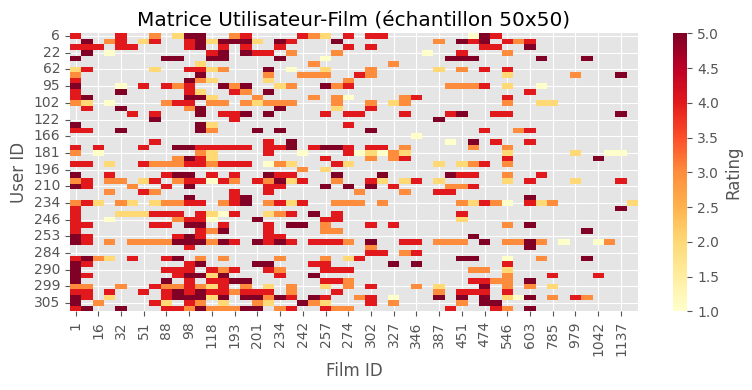

Sparsity de cet échantillon : 72.9%


In [25]:
# Créer une matrice utilisateur-film (échantillon)
# Prendre les 50 premiers utilisateurs et 50 premiers films
sample_users = ratings['user_id'].unique()[:50]
sample_items = ratings['item_id'].unique()[:50]

# Filtrer les données
sample_ratings = ratings[
    (ratings['user_id'].isin(sample_users)) & 
    (ratings['item_id'].isin(sample_items))
]
# Créer la matrice pivot
matrix_sample = sample_ratings.pivot_table(
    index='user_id', 
    columns='item_id', 
    values='rating'
)

# Visualisation
plt.figure(figsize=(8, 4))
sns.heatmap(matrix_sample, cmap='YlOrRd', cbar_kws={'label': 'Rating'})
plt.title('Matrice Utilisateur-Film (échantillon 50x50)')
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

print(f"Sparsity de cet échantillon : {(matrix_sample.isnull().sum().sum() / (50*50)) * 100:.1f}%")

### 4.2 Distribution de l'activité des utilisateurs

Tous les utilisateurs ne notent pas le même nombre de films.
Analysons combien de films chaque utilisateur a noté.

=== ACTIVITÉ DES UTILISATEURS ===

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
dtype: float64


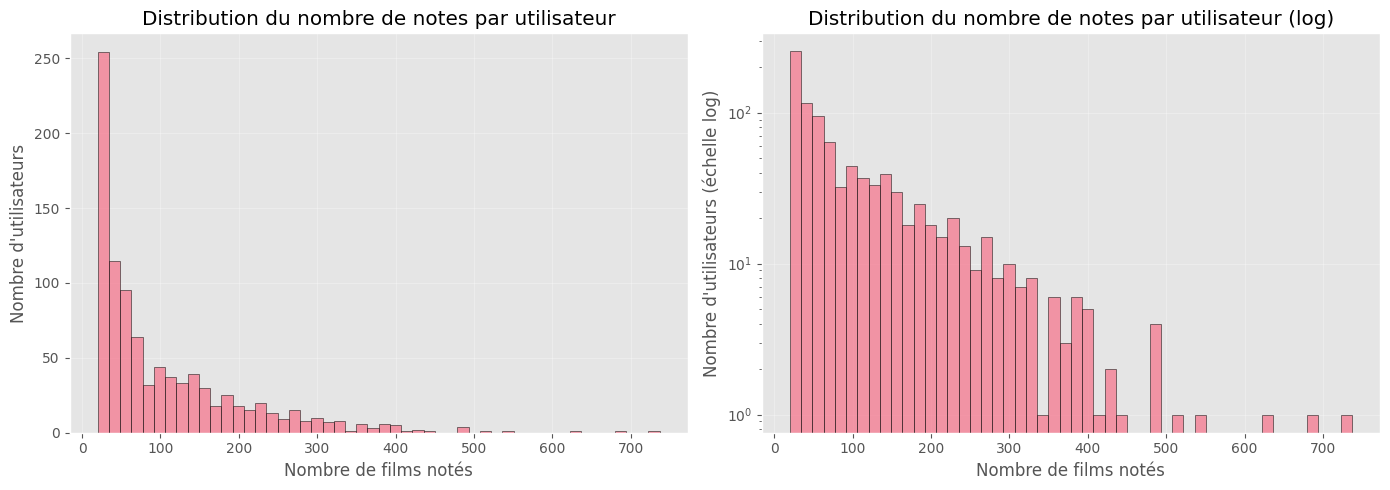

In [15]:
# Nombre de notes par utilisateur
user_activity = ratings.groupby('user_id').size()

# Statistiques
print("=== ACTIVITÉ DES UTILISATEURS ===\n")
print(user_activity.describe())

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(user_activity, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de films notés')
axes[0].set_ylabel('Nombre d\'utilisateurs')
axes[0].set_title('Distribution du nombre de notes par utilisateur')
axes[0].grid(True, alpha=0.3)

# Histogramme en échelle log
axes[1].hist(user_activity, bins=50, edgecolor='black', alpha=0.7, log=True)
axes[1].set_xlabel('Nombre de films notés')
axes[1].set_ylabel('Nombre d\'utilisateurs (échelle log)')
axes[1].set_title('Distribution du nombre de notes par utilisateur (log)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Distribution de la popularité des films

De la même manière, certains films sont beaucoup plus notés que d'autres.

=== POPULARITÉ DES FILMS ===

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64


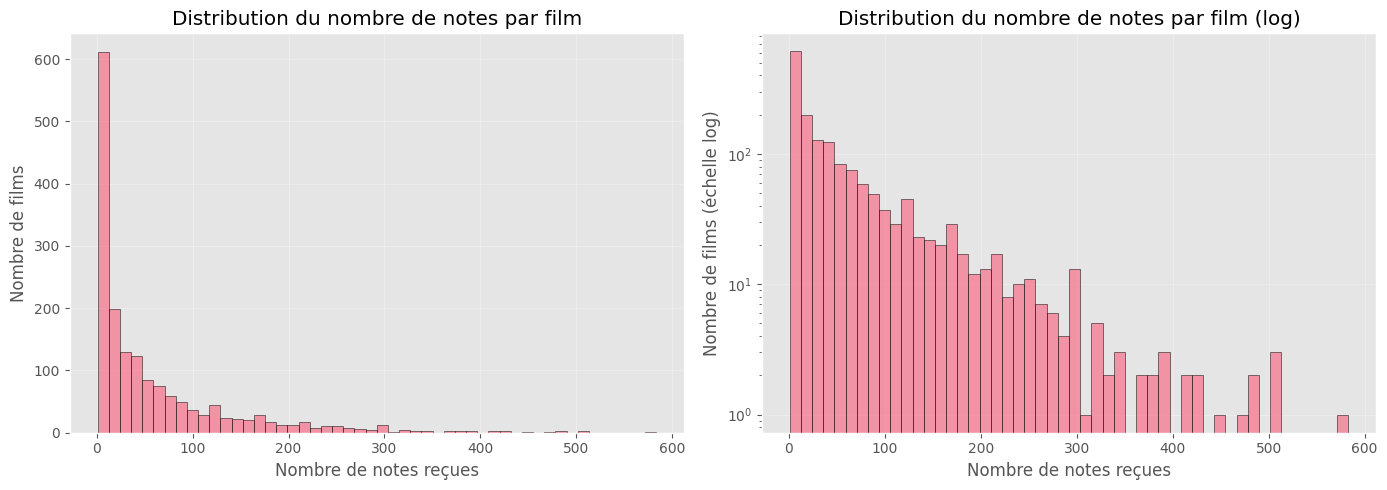

In [17]:
# Nombre de notes par film
item_popularity = ratings.groupby('item_id').size()

# Statistiques
print("=== POPULARITÉ DES FILMS ===\n")
print(item_popularity.describe())

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(item_popularity, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de notes reçues')
axes[0].set_ylabel('Nombre de films')
axes[0].set_title('Distribution du nombre de notes par film')
axes[0].grid(True, alpha=0.3)

# Histogramme en échelle log
axes[1].hist(item_popularity, bins=50, edgecolor='black', alpha=0.7, log=True)
axes[1].set_xlabel('Nombre de notes reçues')
axes[1].set_ylabel('Nombre de films (échelle log)')
axes[1].set_title('Distribution du nombre de notes par film (log)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interprétation de la Sparsity

**Observations** :
- La matrice est très sparse (>90%)
- Certains utilisateurs sont très actifs, d'autres très peu
- Certains films sont très populaires, d'autres presque jamais notés

**Conséquences pour le système de recommandation** :
- **Cold Start Problem** : Difficile de recommander pour les nouveaux utilisateurs/films
- Nécessité de combiner plusieurs approches (Collaborative + Content-Based)
- Importance des algorithmes de Matrix Factorization (SVD, ALS) qui gèrent bien la sparsity

## 5. Analyse de la Distribution "Longue Traîne"

### Qu'est-ce que la Longue Traîne (Long Tail) ?

La **Longue Traîne** est un phénomène observé dans les systèmes de recommandation :
- **Quelques films** (la "tête") sont **extrêmement populaires** (milliers de notes)
- **Beaucoup de films** (la "queue") sont **peu notés** (quelques notes seulement)

**Principe de Pareto (80/20)** : Environ 20% des films génèrent 80% des notes.

**Pourquoi c'est important ?**
- Les algorithmes simples recommandent toujours les films populaires
- Le vrai défi : recommander des films de la "queue" qui correspondent aux goûts de l'utilisateur
- C'est là que les systèmes hybrides apportent de la valeur

In [18]:
# Compter combien de notes chaque film a reçu
ratings_per_movie = ratings.groupby('item_id').size().reset_index(name='num_ratings')
ratings_per_movie = ratings_per_movie.sort_values('num_ratings', ascending=False).reset_index(drop=True)

print("Top 10 films les plus notés :")
print(ratings_per_movie.head(10))
print("\nFilms les moins notés :")
print(ratings_per_movie.tail(10))

Top 10 films les plus notés :
   item_id  num_ratings
0       50          583
1      258          509
2      100          508
3      181          507
4      294          485
5      286          481
6      288          478
7        1          452
8      300          431
9      121          429

Films les moins notés :
      item_id  num_ratings
1672     1571            1
1673     1572            1
1674     1349            1
1675     1574            1
1676     1575            1
1677     1576            1
1678     1577            1
1679     1348            1
1680     1579            1
1681     1682            1


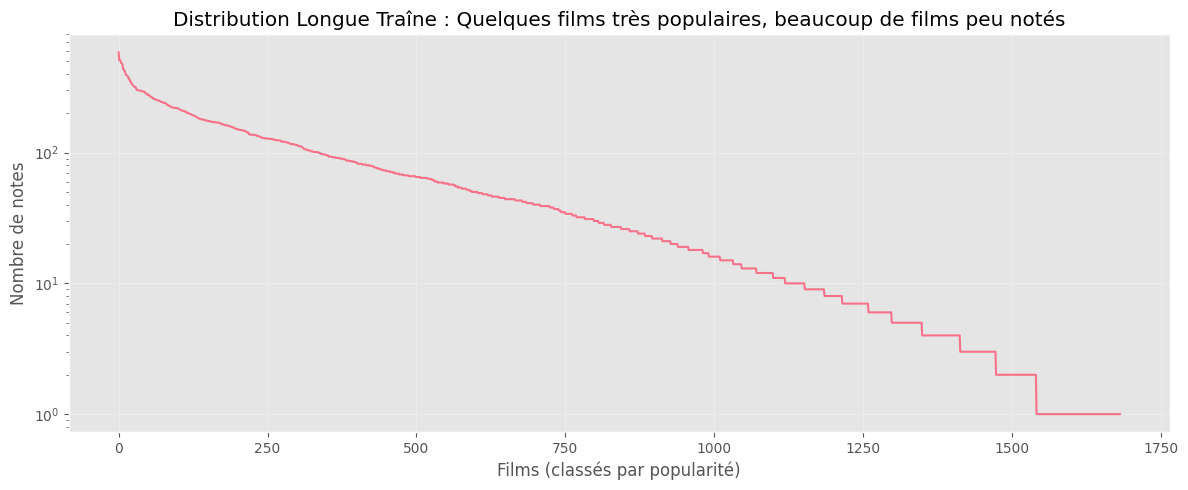

Film le plus noté : 583 notes
Film médian : 27.0 notes
Film le moins noté : 1 notes


In [19]:
# Visualisation de la longue traîne
plt.figure(figsize=(12, 5))

# Graphique : nombre de notes par film (classé du plus au moins populaire)
plt.plot(range(len(ratings_per_movie)), ratings_per_movie['num_ratings'])
plt.xlabel('Films (classés par popularité)')
plt.ylabel('Nombre de notes')
plt.title('Distribution Longue Traîne : Quelques films très populaires, beaucoup de films peu notés')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques simples
print(f"Film le plus noté : {ratings_per_movie['num_ratings'].max()} notes")
print(f"Film médian : {ratings_per_movie['num_ratings'].median()} notes")
print(f"Film le moins noté : {ratings_per_movie['num_ratings'].min()} notes")

## 6. Analyse des Genres

Les genres sont une caractéristique clé pour le Content-Based Filtering (Notebook 2).
Nous allons analyser :
- Quels genres sont les plus fréquents ?
- Quels genres ont les meilleures notes moyennes ?

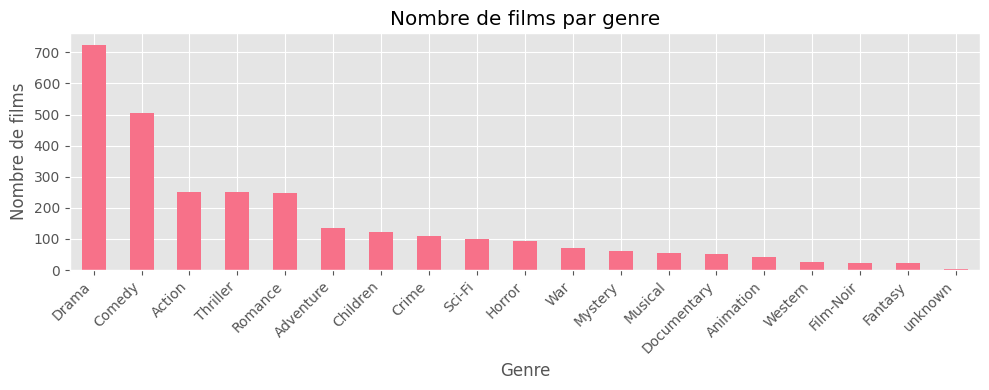

In [20]:
genre_counts = items[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
genre_counts.plot(kind='bar')
plt.title("Nombre de films par genre")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:

print("Genres les plus fréquents :")
print(genre_counts.head(5))

Genres les plus fréquents :
Drama       725
Comedy      505
Action      251
Thriller    251
Romance     247
dtype: int64


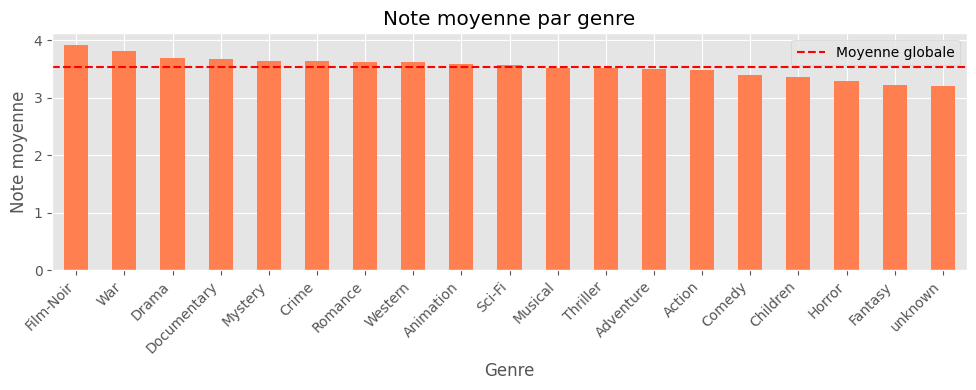

Genres avec les meilleures notes moyennes :
Film-Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
dtype: float64


In [22]:
# Calculer la note moyenne par genre
# Joindre ratings et items
ratings_with_genres = ratings.merge(items[['item_id'] + genre_columns], on='item_id')

# Pour chaque genre, calculer la note moyenne
genre_avg_ratings = {}
for genre in genre_columns:
    # Filtrer les films qui ont ce genre
    genre_ratings = ratings_with_genres[ratings_with_genres[genre] == 1]['rating']
    if len(genre_ratings) > 0:
        genre_avg_ratings[genre] = genre_ratings.mean()

# Convertir en Series et trier
genre_avg_ratings = pd.Series(genre_avg_ratings).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
genre_avg_ratings.plot(kind='bar', color='coral')
plt.title("Note moyenne par genre")
plt.xlabel("Genre")
plt.ylabel("Note moyenne")
plt.xticks(rotation=45, ha='right')
plt.axhline(y=ratings['rating'].mean(), color='red', linestyle='--', label='Moyenne globale')
plt.legend()
plt.tight_layout()
plt.show()

print("Genres avec les meilleures notes moyennes :")
print(genre_avg_ratings.head(5))

## 7. Sauvegarde des Données Nettoyées

Nous sauvegardons les données nettoyées pour les utiliser dans les notebooks suivants :
- **ratings_clean.csv** : Notes avec dates extraites
- **movies_clean.csv** : Films avec titres nettoyés, années, et genres combinés

Cela évite de refaire le nettoyage à chaque fois.

In [24]:
# Créer le dossier de sortie s'il n'existe pas
os.makedirs('../data/processed', exist_ok=True)

# Sauvegarder les ratings nettoyés
ratings_to_save = ratings[['user_id', 'item_id', 'rating', 'timestamp', 'date', 'rating_year', 'rating_month']]
ratings_to_save.to_csv('data/processed/ratings_clean.csv', index=False)

# Sauvegarder les films nettoyés
movies_to_save = items[['item_id', 'title', 'clean_title', 'year', 'genres'] + genre_columns]
movies_to_save.to_csv('data/processed/movies_clean.csv', index=False)

print("Sauvegarde terminée !")
print(f"- ratings_clean.csv : {len(ratings_to_save):,} lignes")
print(f"- movies_clean.csv : {len(movies_to_save):,} lignes")

Sauvegarde terminée !
- ratings_clean.csv : 100,000 lignes
- movies_clean.csv : 1,682 lignes
